In [1]:
import pandas as pd
import jsonlines
from tqdm import tqdm
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Using TensorFlow backend.


In [2]:
#Paths
train_db_path='WikiSQL/data/train.db'
train_data_json_path='WikiSQL/data/train.jsonl'
train_table_json_path='WikiSQL/data/train.tables.jsonl'


dev_db_path='WikiSQL/data/dev.db'
dev_data_json_path='WikiSQL/data/dev.jsonl'
dev_table_json_path='WikiSQL/data/dev.tables.jsonl'

test_db_path='WikiSQL/data/test.db'
test_data_json_path='WikiSQL/data/test.jsonl'
test_table_json_path='WikiSQL/data/test.tables.jsonl'

In [3]:
cond_ops = ['=', '>', '<', 'OP']

In [4]:
def get_col_tokens(table_json_path):
    tokens=[]
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            for header in obj['header']:
                tokens.append(header)
    return tokens

In [5]:
def get_question_tokens(data_json_path):
    tokens=[]
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            tokens.append(obj['question'])
    return tokens

In [6]:
texts=[]
texts.extend(get_col_tokens(train_table_json_path))
texts.extend(get_col_tokens(dev_table_json_path))
texts.extend(get_col_tokens(test_table_json_path))

18585it [00:00, 35700.15it/s]
2716it [00:00, 33532.90it/s]
5230it [00:00, 32844.29it/s]


In [7]:
texts.extend(get_question_tokens(train_data_json_path))
texts.extend(get_question_tokens(dev_data_json_path))
texts.extend(get_question_tokens(test_data_json_path))

56355it [00:00, 153766.69it/s]
8421it [00:00, 114118.09it/s]
15878it [00:00, 150721.41it/s]


In [8]:
tokenizer=Tokenizer(char_level=True,lower=True)
tokenizer.fit_on_texts(texts)

In [9]:
max_token_index=len(tokenizer.index_word.keys())+1
max_token_index

1246

In [10]:
def text2seq(text):
    return np.ravel([tokenizer.texts_to_sequences([text])])

In [11]:
max_len=0
for text in texts:
    if len(text2seq(text))>max_len:
        max_len=len(text2seq(text))
max_len

419

In [12]:
def text2seq(text):
    return np.ravel(pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=max_len,padding='post'))

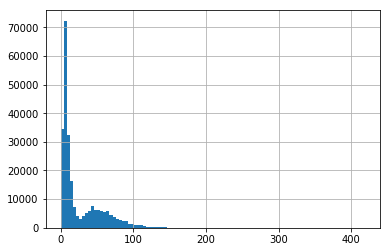

In [13]:
df = pd.Series(texts)
df.str.len().hist(bins=100)
plt.show()

In [14]:
del texts

In [15]:
#make a dict to keep track of all the columns of all the tables
def get_table(table_json_path):
    tables={}
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            tables[obj['id']]={'headers':[],'types':[]}
            tables[obj['id']]['headers']=obj['header']
            tables[obj['id']]['types']=obj['types']
    return tables

In [16]:
train_tables=get_table(train_table_json_path)
dev_tables=get_table(dev_table_json_path)
test_tables=get_table(test_table_json_path)

18585it [00:00, 33517.47it/s]
2716it [00:00, 41724.43it/s]
5230it [00:00, 36280.39it/s]


In [17]:
def get_where_cols_ops(dict_obj,tables):
    temp=tables[dict_obj['table_id']]['headers']
    where_cols = []
    ops=[]
    for cond in dict_obj['sql']['conds']:
        where_cols.append(temp[cond[0]])
        ops.append(cond_ops[cond[1]])
    return where_cols,ops
    

In [18]:
def get_dataset(data_json_path,table):
    #read the jsonl file
    Q=[]
    C=[]
    y=[]
    global tokenizer
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            where_cols,ops=get_where_cols_ops(obj,table)
            question=obj['question']
            
    
            #tokenized representation
            question=text2seq(question)
            for i in range(len(where_cols)):
                
                Q.append(question)
                C.append(text2seq(where_cols[i]))
                y.append(ops[i])
            
    return Q,C,y

In [19]:
Q_train,C_train,y_train=get_dataset(train_data_json_path,train_tables)

56355it [00:05, 9397.34it/s]


In [20]:
Q_dev,C_dev,y_dev=get_dataset(dev_data_json_path,dev_tables)

8421it [00:00, 9483.12it/s]


In [21]:
pd.Series(y_train).value_counts()

=    63880
>     6606
<     6243
dtype: int64

In [22]:
from sklearn.utils.class_weight import compute_class_weight
class_weight=compute_class_weight('balanced',np.unique(y_train),y_train)
class_weight

array([4.09680175, 0.40038092, 3.87168231])

In [23]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_dev=lb.transform(y_dev)

In [24]:
from joblib import dump, load
dump(lb,'lb_ops.joblib')

['lb_ops.joblib']

In [45]:
y_train.cumsum(axis=0)

array([[    0,     1,     0],
       [    0,     2,     0],
       [    0,     3,     0],
       ...,
       [ 6243, 63878,  6606],
       [ 6243, 63879,  6606],
       [ 6243, 63880,  6606]])

In [46]:
#dimension
d=64
from keras.models import Model
from keras.layers import Input, GRU, Dense ,Flatten , Concatenate,Bidirectional
from keras.layers.embeddings import Embedding
from keras.constraints import max_norm
from keras import regularizers

In [56]:
# Define an input sequence and process it.
question_input = Input(shape=(max_len,),name='Q_input')
column_input = Input(shape=(max_len,),name='C_input')

embedding= Embedding(max_token_index, d, input_length=max_len,name='embedding')
# embedding_C= Embedding(max_token_index, d, input_length=max_len,name='embedding_C')
#                      embeddings_constraint=max_norm(2.),
#                      embeddings_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))

Q_embedding= embedding(question_input)
C_embedding= embedding(column_input)



encoder_question = Bidirectional(GRU(d, return_state=True))
_ , Q_state_h1, Q_state_h2 = encoder_question(Q_embedding)

encoder_column = Bidirectional(GRU(d, return_state=True))
_ , C_state_h1, C_state_h2 = encoder_column(C_embedding)


con=Concatenate()([Q_state_h1,Q_state_h2,C_state_h1,C_state_h2])


final=Dense(3,activation='softmax')(con)

model = Model([question_input, column_input], final)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Q_input (InputLayer)            (None, 419)          0                                            
__________________________________________________________________________________________________
C_input (InputLayer)            (None, 419)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 419, 64)      79744       Q_input[0][0]                    
                                                                 C_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) [(None, 128), (None, 49536       embedding[0][0]                  
__________

In [57]:
from keras import backend as K

def first_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 0), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc


def second_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 1), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc



def third_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 2), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc



In [58]:
from keras import optimizers

opt = optimizers.Adam()

In [59]:
# Run training
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy',
                                                                     first_class_accuracy,
                                                                     second_class_accuracy,
                                                                     third_class_accuracy])

In [60]:
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.

In [61]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='select_ops_best_model.h5', monitor='val_loss', save_best_only=True)]

In [64]:
history=model.fit([Q_train,C_train], y_train,batch_size=batch_size, epochs=epochs, verbose=1,
                  class_weight=class_weight,
                callbacks=callbacks, validation_data=([Q_dev,C_dev],y_dev))

Train on 76729 samples, validate on 11545 samples
Epoch 1/100
76729/76729 [==============================] - 857s 11ms/step - loss: 0.4582 - acc: 0.8364 - first_class_accuracy: 0.1991 - second_class_accuracy: 0.8602 - third_class_accuracy: 0.1939 - val_loss: 0.4193 - val_acc: 0.8319 - val_first_class_accuracy: 0.1720 - val_second_class_accuracy: 0.8754 - val_third_class_accuracy: 0.3103
Epoch 2/100
76729/76729 [==============================] - 942s 12ms/step - loss: 0.3336 - acc: 0.8657 - first_class_accuracy: 0.4743 - second_class_accuracy: 0.9146 - third_class_accuracy: 0.4822 - val_loss: 0.2827 - val_acc: 0.8834 - val_first_class_accuracy: 0.5781 - val_second_class_accuracy: 0.9274 - val_third_class_accuracy: 0.4870
Epoch 3/100
76729/76729 [==============================] - 942s 12ms/step - loss: 0.2430 - acc: 0.9031 - first_class_accuracy: 0.6575 - second_class_accuracy: 0.9490 - third_class_accuracy: 0.6719 - val_loss: 0.2168 - val_acc: 0.9103 - val_first_class_accuracy: 0.5804 -

In [65]:
Q_test,C_test,y_test=get_dataset(test_data_json_path,test_tables)

15878it [00:01, 13661.70it/s]


In [66]:
y_test=lb.transform(y_test)

In [67]:
model.load_weights('select_ops_best_model.h5')

In [68]:
model.evaluate([Q_test,C_test],y_test,verbose=1)

21846/21846 [==============================] - 50s 2ms/step


[0.1524159171725142,
 0.9326192438247756,
 0.5447706026667853,
 0.9687763402655902,
 0.5702525642240011]

In [69]:
model.evaluate([Q_train,C_train],y_train,verbose=1)

76729/76729 [==============================] - 176s 2ms/step


[0.12127571474402668,
 0.9456007506994387,
 0.5698899705440841,
 0.9768333085488969,
 0.6050568816003008]

In [70]:
model.evaluate([Q_dev,C_dev],y_dev,verbose=1)

11545/11545 [==============================] - 26s 2ms/step


[0.15254271694169824,
 0.9307925508310393,
 0.5380629533596185,
 0.9666724815971535,
 0.5742019966378615]

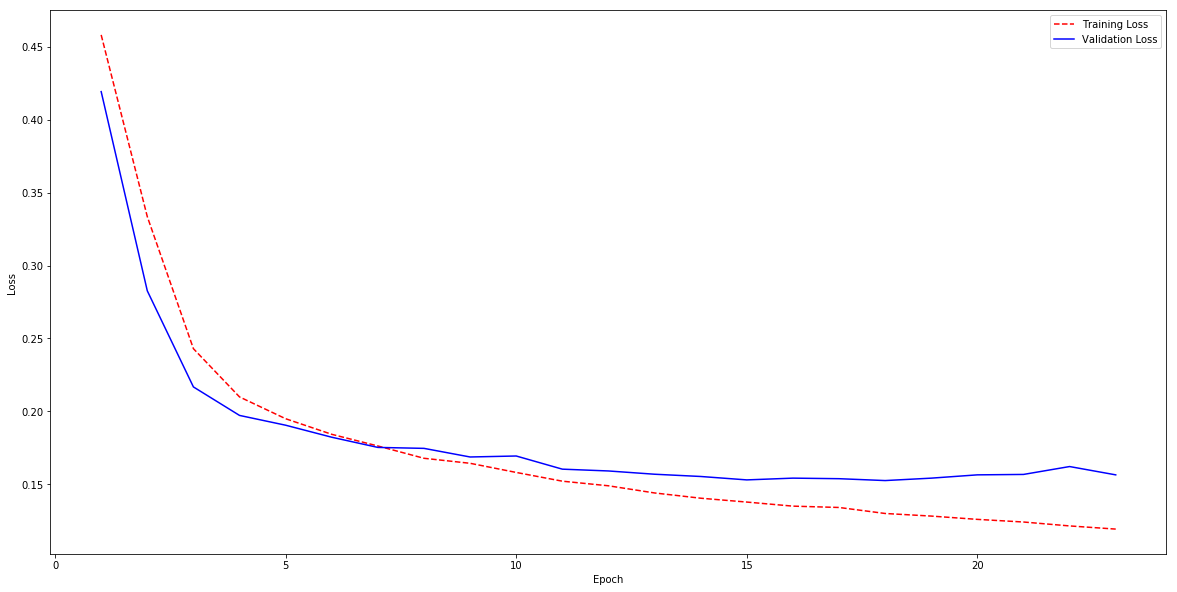

In [71]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.figure(figsize=(20,10))
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

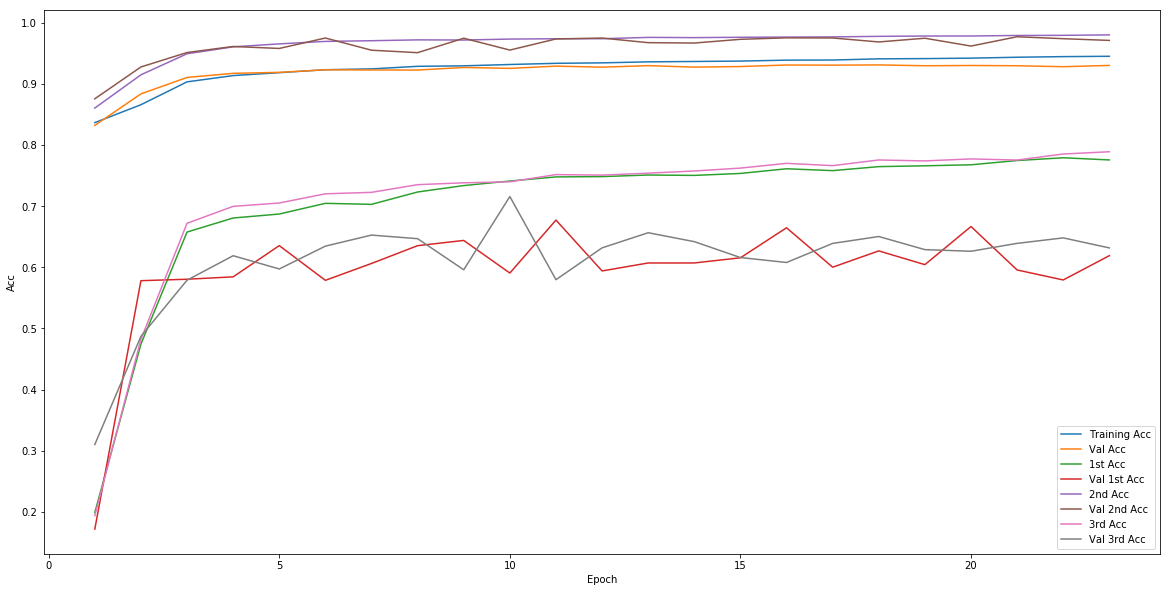

In [72]:

# Get training and test loss histories
training_acc = history.history['acc']
val_acc = history.history['val_acc']

training_one_acc = history.history['first_class_accuracy']
val_one_acc = history.history['val_first_class_accuracy']

training_second_acc = history.history['second_class_accuracy']
val_second_acc = history.history['val_second_class_accuracy']

training_third_acc = history.history['third_class_accuracy']
val_third_acc = history.history['val_third_class_accuracy']


# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

plt.figure(figsize=(20,10))
# Visualize loss history
plt.plot(epoch_count, training_acc)
plt.plot(epoch_count, val_acc)

plt.plot(epoch_count, training_one_acc)
plt.plot(epoch_count, val_one_acc)

plt.plot(epoch_count, training_second_acc)
plt.plot(epoch_count, val_second_acc)

plt.plot(epoch_count, training_third_acc)
plt.plot(epoch_count, val_third_acc)


plt.legend(['Training Acc', 'Val Acc',
           '1st Acc','Val 1st Acc',
           '2nd Acc','Val 2nd Acc',
           '3rd Acc','Val 3rd Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show();